# Model
GPT-4o-mini


## Prompt 1:
/ask there are 2 jpg files in image. directory. ./image/img_left.jpg and ./image/img_right.jpg. I would like to use OpenCV in Python (jupyter) to identify features in both images using Sift and then matching them and displaying the matches on the jupyter cell. Can you help write the code?

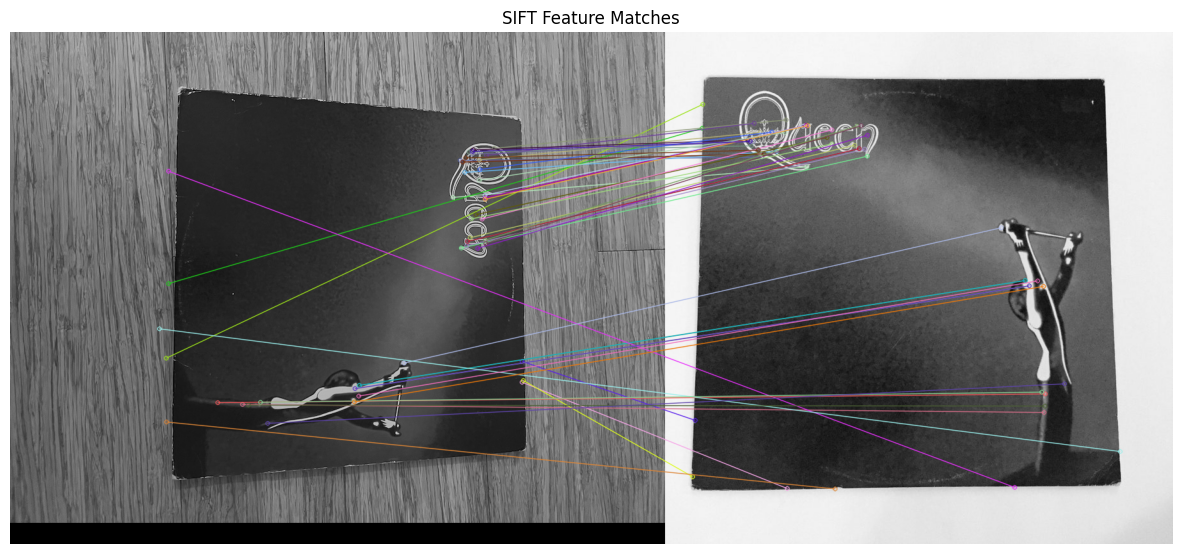

In [1]:
import cv2
import matplotlib.pyplot as plt

# Load the images
img_left = cv2.imread('./image/img_left.jpg', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('./image/img_right.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find keypoints and descriptors
keypoints_left, descriptors_left = sift.detectAndCompute(img_left, None)
keypoints_right, descriptors_right = sift.detectAndCompute(img_right, None)

# Create a BFMatcher object
bf_matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf_matcher.match(descriptors_left, descriptors_right)

# Sort the matches based on distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw matches
img_matches = cv2.drawMatches(img_left, keypoints_left, img_right, keypoints_right, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches
plt.figure(figsize=(15, 10))
plt.imshow(img_matches)
plt.axis('off')
plt.title('SIFT Feature Matches')
plt.show()

## Prompt 2
This is pretty great. I heard that there is a RANSAC algorithm to eliminate flast matches. Can you improve the code with this algorithm?

## Prompt 4
can you put all the code in one place? I mean combining the two answers


In [2]:
import cv2
import numpy as np

def ransac_homography(src_pts, dst_pts, threshold=5, iterations=1000):
    best_inliers_count = 0
    best_homography = None

    for _ in range(iterations):
        # Randomly select 4 points
        idx = np.random.randint(0, len(src_pts), 4)
        src_selected = src_pts[idx]
        dst_selected = dst_pts[idx]

        # Compute homography
        H, _ = cv2.findHomography(src_selected, dst_selected, 0)

        # Project points and calculate the error
        if H is not None:
            projected_pts = cv2.perspectiveTransform(src_pts.reshape(-1, 1, 2), H)
            error = np.linalg.norm(projected_pts - dst_pts.reshape(-1, 1, 2), axis=2)

            # Count inliers
            inliers_count = np.sum(error < threshold)

            # Update best model if necessary
            if inliers_count > best_inliers_count:
                best_inliers_count = inliers_count
                best_homography = H

    return best_homography

# Load images
img1 = cv2.imread('./image/img_left.jpg', cv2.IMREAD_GRAYSCALE)  # Source image
img2 = cv2.imread('./image/img_right.jpg', cv2.IMREAD_GRAYSCALE)  # Destination image

# Detect ORB features and compute descriptors
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

# Match descriptors using the BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Extract matched keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches])
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# Apply RANSAC to find a robust homography
homography = ransac_homography(src_pts, dst_pts)

if homography is not None:
    print("Found a homography matrix:")
    print(homography)
else:
    print("Homography could not be computed.")

Found a homography matrix:
[[-9.22792624e-02  1.02858785e+00 -1.21456864e+01]
 [-1.12730542e+00  8.15656519e-03  9.58923865e+02]
 [-2.16716347e-04  3.16104723e-05  1.00000000e+00]]


## Prompt 5

and now visualise the improved matches please?

In [ ]:
import cv2
import numpy as np

def ransac_homography(src_pts, dst_pts, threshold=5, iterations=1000):
    best_inliers_count = 0
    best_homography = None
    best_inliers = None

    for _ in range(iterations):
        # Randomly select 4 points
        idx = np.random.randint(0, len(src_pts), 4)
        src_selected = src_pts[idx]
        dst_selected = dst_pts[idx]

        # Compute homography
        H, _ = cv2.findHomography(src_selected, dst_selected, 0)

        # Project points and calculate the error
        if H is not None:
            projected_pts = cv2.perspectiveTransform(src_pts.reshape(-1, 1, 2), H)
            error = np.linalg.norm(projected_pts - dst_pts.reshape(-1, 1, 2), axis=2)

            # Count inliers
            inliers = error < threshold
            inliers_count = np.sum(inliers)

            # Update best model if necessary
            if inliers_count > best_inliers_count:
                best_inliers_count = inliers_count
                best_homography = H
                best_inliers = inliers

    return best_homography, best_inliers

# Load images
img1 = cv2.imread('./image/img_left.jpg', cv2.IMREAD_GRAYSCALE)  # Source image
img2 = cv2.imread('./image/img_right.jpg', cv2.IMREAD_GRAYSCALE)  # Destination image

# Detect ORB features and compute descriptors
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

# Match descriptors using the BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Extract matched keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches])
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# Apply RANSAC to find a robust homography
homography, inliers = ransac_homography(src_pts, dst_pts)

# Visualize matches
matches_mask = inliers.flatten() if inliers is not None else None
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), matchesMask=matches_mask.tolist() if matches_mask is not None else [], flags=0)

# Draw matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, **draw_params)

# Show the result
cv2.imshow("Matches with RANSAC Inliers", img_matches)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Prompt 6

This is in jupyter so following code needs to be replaced:
# Show the result
cv2.imshow("Matches with RANSAC Inliers", img_matches)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Prompt 7
/ask So close but there is one more error. In Jupyter cv2.imshow will not work and will crash the kernel. Can you fix the following code?


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def ransac_homography(src_pts, dst_pts, threshold=5, iterations=1000):
    best_inliers_count = 0
    best_homography = None
    best_inliers = None

    for _ in range(iterations):
        # Randomly select 4 points
        idx = np.random.randint(0, len(src_pts), 4)
        src_selected = src_pts[idx]
        dst_selected = dst_pts[idx]

        # Compute homography
        H, _ = cv2.findHomography(src_selected, dst_selected, 0)

        # Project points and calculate the error
        if H is not None:
            projected_pts = cv2.perspectiveTransform(src_pts.reshape(-1, 1, 2), H)
            error = np.linalg.norm(projected_pts - dst_pts.reshape(-1, 1, 2), axis=2)

            # Count inliers
            inliers = error < threshold
            inliers_count = np.sum(inliers)

            # Update best model if necessary
            if inliers_count > best_inliers_count:
                best_inliers_count = inliers_count
                best_homography = H
                best_inliers = inliers

    return best_homography, best_inliers

# Load images
img1 = cv2.imread('./image/img_left.jpg', cv2.IMREAD_GRAYSCALE)  # Source image
img2 = cv2.imread('./image/img_right.jpg', cv2.IMREAD_GRAYSCALE)  # Destination image


# Detect ORB features and compute descriptors
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

# Match descriptors using the BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Extract matched keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches])
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# Apply RANSAC to find a robust homography
homography, inliers = ransac_homography(src_pts, dst_pts)

# Visualize matches
matches_mask = inliers.flatten() if inliers is not None else None
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), matchesMask=matches_mask.tolist() if matches_mask is not None else [], flags=0)

# Draw matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, **draw_params)

# Show the result in Jupyter Notebook
plt.figure(figsize=(12, 6))
plt.imshow(img_matches)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Matches with RANSAC Inliers")
plt.show()

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'drawMatches'
> Overload resolution failed:
>  - Can't parse 'matchesMask'. Sequence item with index 0 has a wrong type
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)
>  - Can't parse 'matchesMask'. Sequence item with index 0 has a wrong type
>  - drawMatches() missing required argument 'matchesThickness' (pos 7)


/fix

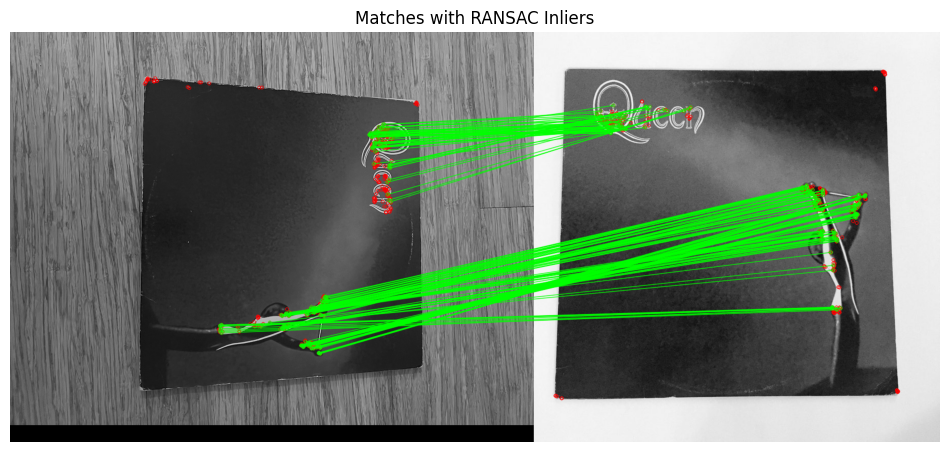

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def ransac_homography(src_pts, dst_pts, threshold=5, iterations=1000):
    best_inliers_count = 0
    best_homography = None
    best_inliers = None

    for _ in range(iterations):
        # Randomly select 4 points
        idx = np.random.randint(0, len(src_pts), 4)
        src_selected = src_pts[idx]
        dst_selected = dst_pts[idx]

        # Compute homography
        H, _ = cv2.findHomography(src_selected, dst_selected, 0)

        # Project points and calculate the error
        if H is not None:
            projected_pts = cv2.perspectiveTransform(src_pts.reshape(-1, 1, 2), H)
            error = np.linalg.norm(projected_pts - dst_pts.reshape(-1, 1, 2), axis=2)

            # Count inliers
            inliers = error < threshold
            inliers_count = np.sum(inliers)

            # Update best model if necessary
            if inliers_count > best_inliers_count:
                best_inliers_count = inliers_count
                best_homography = H
                best_inliers = inliers

    return best_homography, best_inliers

# Load images
img1 = cv2.imread('./image/img_left.jpg', cv2.IMREAD_GRAYSCALE)  # Source image
img2 = cv2.imread('./image/img_right.jpg', cv2.IMREAD_GRAYSCALE)  # Destination image

# Detect ORB features and compute descriptors
orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(img1, None)
keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

# Match descriptors using the BFMatcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Extract matched keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches])
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# Apply RANSAC to find a robust homography
homography, inliers = ransac_homography(src_pts, dst_pts)

# Visualize matches
matches_mask = inliers.flatten().astype(int) if inliers is not None else None
draw_params = dict(matchColor=(0, 255, 0), singlePointColor=(255, 0, 0), 
                   matchesMask=matches_mask.tolist() if matches_mask is not None else [], 
                   flags=0)

# Draw matches
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, **draw_params)

# Show the result in Jupyter Notebook
plt.figure(figsize=(12, 6))
plt.imshow(img_matches)
plt.axis('off')  # Turn off axis numbers and ticks
plt.title("Matches with RANSAC Inliers")
plt.show()